# Import

In [1]:
%pylab inline

import numpy as np
import scipy.sparse as sps

import numba
from numba import jit
import random

from gurobipy import *
import gurobipy as grb

from platform import python_version
print('Python:', python_version())
print('Numba: ', numba.__version__)

Populating the interactive namespace from numpy and matplotlib
Python: 3.7.6
Numba:  0.48.0


# Functions

## Ising energy

In [2]:
@jit(nopython=True)
def get_ising_energy(J, spins):
    """Returns Ising energy"""
    return - np.dot(spins.T, np.dot(J, spins))[0, 0]


@jit(nopython=True)
def get_ising_energy_sparse(data, indices, indptr, N, spins):
    """Returns Ising energy for sparse coupling matrix J"""
    return - np.dot(spins.T, sparse_mat_vec_numba(spins, data, indices, indptr, N))[0, 0]


@jit(nopython=True)
def sparse_mat_vec_numba(x, data, indices, indptr, N):
    """Custom sparse matvec product with numba"""
    Ax = np.zeros_like(x)
    for i in range(N):
        Ax_i = 0.0        
        for ind_data in range(indptr[i], indptr[i+1]):
            j = indices[ind_data]
            Ax_i += data[ind_data] * x[j, 0]
        Ax[i, 0] = Ax_i            

    return Ax

## Ising methods

In [22]:
def solve_Ising_model(J, method, connectivity):
    """
    Available methods: 
    - Hopfield-Tank neural networks ('hopfield')
    - The commercial exact solver ('gurobi')
    """
    
    additional_data = {}
    if method == 'hopfield':
        spins, energy_min, prob = hopfield_solver(J, connectivity)
        additional_data['prob'] = prob
    elif method == 'gurobi':
        spins, energy_min, energy_gap, time_gurobi = gurobi_solver(J)
        additional_data['energy_gap'] = energy_gap
        additional_data['time_gurobi'] = time_gurobi
    else:
        print('The method is not implemented, please try one of ', help(solve_Ising_model))

    return spins, energy_min, additional_data

### Hopfield solver

In [4]:
def hopfield_solver(J, connectivity):
    N = shape(J)[0]
    N_iter, dt, tau, u0_IC, N_IC = params_hopfield()
    
    # number of timesteps to save for studying dynamics
    N_time = 1
    
    N_t = int(N_iter / N_time)
    
    if connectivity == 'dense':
        spins_set, energy_Ising_set = hopfield_net_model(N_IC, u0_IC, J, tau, N_t, dt, N_time, N)
    elif connectivity == 'sparse':
        J_sparse = sps.csr_matrix(J)
        J_data = J_sparse.data
        J_indices = J_sparse.indices
        J_indptr = J_sparse.indptr
        spins_set, energy_Ising_set = hopfield_net_model_sparse(N_IC, u0_IC, J_data, J_indices, 
                                                                J_indptr, tau, N_t, dt, N_time, N)
    
    ind_min = np.argmin(energy_Ising_set)
    energy_min, spins = energy_Ising_set[-1, ind_min], spins_set[:, -1, ind_min]
    prob = len(np.nonzero(energy_Ising_set[-1, :] == energy_min)[0]) / N_IC

    return spins, energy_min, prob

In [5]:
# Functions for the Hopfield solver on dense coupling matrices J
@jit(nopython=True, parallel=True)
def hopfield_net_model(N_IC, u0_IC, J, tau, N_t, dt, N_time, N):
    spins_set_IC = np.zeros((N, N_time, N_IC))
    energy_ising_set_IC = np.zeros((N_time, N_IC))

    for ind_IC in numba.prange(N_IC):
        spins_set, H_Ising_set = hopfield_net(u0_IC[ind_IC, 0], J, tau, N_t, dt, N_time, N)
        
        spins_set_IC[:, :, ind_IC] = spins_set
        energy_ising_set_IC[:, ind_IC] = H_Ising_set

    return spins_set_IC, energy_ising_set_IC


@jit(nopython=True)
def hopfield_net(u0, J, tau, N_t, dt, N_time, N):
    spins_set = np.zeros((N, N_time))
    H_Ising_set = np.zeros((N_time))

    u_t = 0.01 * np.random.random((N, 1))
    for ind_time in range(N_time):
        u_t, v = hopfield_net_iter(u_t, u0, J, tau, N_t, dt, ind_time)
        spins_set[:, ind_time] = v[:, 0]
        H_Ising_set[ind_time] = get_ising_energy(J, np.sign(v))
    return spins_set, H_Ising_set


@jit(nopython=True)
def hopfield_net_iter(u_t, u0, J, tau, N_t, dt, ind_time):
    for ind_t in range(N_t):
        v = np.tanh(u_t / u0)
        rhs_u = - u_t / tau + np.dot(J, v)
        u_t = u_t + rhs_u * dt
    return u_t, v

In [6]:
# Functions for the Hopfield solver on sparse coupling matrices J
@jit(nopython=True, parallel=True)
def hopfield_net_model_sparse(N_IC, u0_IC, J_data, J_indices, J_indptr, tau, N_t, dt, N_time, N):
    spins_set_IC = np.zeros((N, N_time, N_IC))
    energy_ising_set_IC = np.zeros((N_time, N_IC))

    for ind_IC in numba.prange(N_IC):
        spins_set, H_Ising_set = hopfield_net_sparse(u0_IC[ind_IC, 0], J_data, J_indices, J_indptr, 
                                                     tau, N_t, dt, N_time, N)
        spins_set_IC[:, :, ind_IC] = spins_set
        energy_ising_set_IC[:, ind_IC] = H_Ising_set

    return spins_set_IC, energy_ising_set_IC


@jit(nopython=True)
def hopfield_net_sparse(u0, J_data, J_indices, J_indptr, tau, N_t, dt, N_time, N):
    spins_set = np.zeros((N, N_time))
    H_Ising_set = np.zeros((N_time))

    u_t = 0.01 * np.random.random((N, 1))
    for ind_time in range(N_time):
        u_t, v = hopfield_net_iter_sparse(u_t, u0, J_data, J_indices, J_indptr, tau, 
                                          N_t, dt, ind_time, N)
        spins_set[:, ind_time] = v[:, 0]
        H_Ising_set[ind_time] = get_ising_energy_sparse(J_data, J_indices, J_indptr, N, np.sign(v))
    
    return spins_set, H_Ising_set


@jit(nopython=True)
def hopfield_net_iter_sparse(u_t, u0, J_data, J_indices, J_indptr, tau, N_t, dt, ind_time, N):
    for ind_t in range(N_t):
        v = np.tanh(u_t / u0)
        rhs_u = - u_t / tau + sparse_mat_vec_numba(v, J_data, J_indices, J_indptr, N)
        u_t = u_t + rhs_u * dt
    
    return u_t, v

### Gurobi solver

In [7]:
def gurobi_solver(J):
    """Gurobi solver for the Ising model"""
    N = shape(J)[0]
    output_flag, time_limit = params_gurobi()

    J_boolean, fields, offset = get_J_for_boolean_spins(J)
    model_ising = get_ising_model_gurobi(J_boolean, fields, N, output_flag, time_limit)
    model_ising.optimize()

    energy_min = model_ising.ObjVal + offset
    spins = np.zeros((N, 1))
    spins[:, 0] = model_ising.X
    spins[spins == 0] = -1
    energy_gap = model_ising.MIPGap
    time_gurobi = model_ising.Runtime

    return spins, energy_min, energy_gap, time_gurobi


def get_ising_model_gurobi(J_boolean, fields, N, output_flag, time_limit):
    """Define the Ising model for Gurobi solver"""
    ind_nonzero = list(np.nonzero(np.triu(J_boolean)))

    opt_gurobi = grb.Model(name="Ising Model")
    opt_gurobi.params.OutputFlag = output_flag
    opt_gurobi.params.NonConvex = -1

    spins = {}
    for i in range(N):
        spins[i] = opt_gurobi.addVar(lb=0, ub=1, vtype = GRB.BINARY)
    opt_gurobi.update()

    energy = 0.
    for i, j in zip(ind_nonzero[0], ind_nonzero[1]):
        energy += - 2. * J_boolean[i, j] * spins[i] * spins[j]

    for i in range(N):
        energy += fields[i, 0] * spins[i]

    opt_gurobi.setParam("TimeLimit", time_limit)
    opt_gurobi.setObjective(energy, GRB.MINIMIZE)
    opt_gurobi.update()
    
    return opt_gurobi


def get_J_for_boolean_spins(JJ):
    """Define the coupling matrix in terms of boolean spins [0, 1]"""
    N = shape(JJ)[0]
    fields = np.zeros((N, 1))
    J = np.zeros((N, N))
    J[:, :] = 4. * JJ
    fields[:, 0] = 4. * np.sum(JJ, 0)
    offset = - np.sum(JJ)
    
    return J, fields, offset

## Ising coupling matrices

In [23]:
def generate_ising_model(N, model, distribution):  
    """
    Available Ising models:
    - Sherrington-Kirkpatrick ('sk')
    - 3-regular maximum cut ('maxcut')
    - Mobius ladder ('mobius')
    
    Available coupling distributions: 
    - 'unweighted'
    - 'bimodal'
    - 'gaussian'
    """
    
    if model == 'sk':
        J = get_sk_model(N, distribution)
    elif model == 'maxcut':
        J = get_maxcut_model(N, distribution)
    elif model == 'mobius':
        J = get_mobius_model(N, distribution)
    else:
        print('Warning: the Ising model: ', str(model), 'is not supported, consider one of: ')
        help(generate_ising_model)

    return J

### SK, Mobius, Maxcut models

In [9]:
def get_sk_model(N, distribution):
    """The Sherrington-Kirkpatrick model"""
    
    if distribution == 'unweighted':
        J = - np.ones((N, N))
    elif distribution == 'bimodal':
        J = np.random.choice([-1, 1], size=(N, N))
    elif distribution == 'gaussian':
        J = np.random.normal(0, 1., size=(N, N))
    else:
        print('Warning: not supported distribution name')

    J = np.triu(J) + np.triu(J).T
    np.fill_diagonal(J, 0)
    
    check_model_is_symmetric_and_regular(J, N - 1)
    
    return J


def get_mobius_model(N, distribution):
    """The Ising model on the Mobius Ladder graph (N is even)"""
    
    if N % 2 != 0:
        print('Warning: N has to be even for the Mobius Ladder graph')

    J = np.zeros((N, N))
    n = int(N/2)
    
    if distribution == 'unweighted':
        np.fill_diagonal(J[:, n:], -1)
        np.fill_diagonal(J[:, 1:], -1)
        J[0, -1] = -1
    elif distribution == 'bimodal':
        J[:, :] = np.diag(np.random.choice([-1, 1], size=(N - n)), n) + np.diag(np.random.choice([-1, 1], size=(N-1)), 1)
        J[0, -1] = np.random.choice([-1, 1])
    elif distribution == 'gaussian':
        J[:, :] = np.diag(np.random.normal(0,1, size=(N - n)), n) + np.diag(np.random.normal(0,1, size=(N-1)), 1)
        J[0, -1] = np.random.normal(0, 1)
    else:
        print('Warning: not supported distribution name')

    J = J + J.T
    check_model_is_symmetric_and_regular(J, 3)
    
    return J

def get_maxcut_model(N, distribution):
    """The Ising model on 3-regular graph"""
    J_mobius = get_mobius_model(N, distribution)
    J = rewire_regular_graph(J_mobius, int(3 * N))
    check_model_is_symmetric_and_regular(J, 3)
    
    return J


def check_model_is_symmetric_and_regular(J, k):
    """Check if the coupling matrix of the Ising model is symmetric and regular"""
    N = len(J)
    if not np.all(np.array([len(np.nonzero(J[:, i])[0]) for i in range(N)]) == k):
        print('Warning: the Ising model is NOT of degree %d' % k)
    if not np.all(J - J.T == 0):
        print('Warning: the Ising model is NOT symmetric')

### Rewiring procedure

In [10]:
def rewire_two_edges(ind_edges, n_rewirings_done, J, i, i1, i2, j1, j2):
    """Rewire two given edges of the coupling matrix J"""
    val1 = J[i1, i2]
    val2 = J[j1, j2]
    
    # remove old edges
    J[i1, i2], J[i2, i1] = 0, 0
    J[j1, j2], J[j2, j1] = 0, 0
    
    # create two new edges
    J[i1, j2], J[j2, i1] = val1, val1
    J[j1, i2], J[i2, j1] = val2, val2

    ind_edges.pop(i)
    n_rewirings_done += 1
    rewiring_is_found = True
    
    return ind_edges, n_rewirings_done, J, rewiring_is_found


def rewire_regular_graph(JJ, N_rewirings):
    """Do N_rewirings for the coupling matrix J"""
    J = np.zeros((shape(JJ)[0], shape(JJ)[0]))
    J[:, :] = JJ
    connectivity = len(np.nonzero(J[:, 0])[0])
    N_nonzeros = int(connectivity * shape(J)[0] / 2.)

    n_rewirings_done = 0
    while n_rewirings_done != N_rewirings:
        # count nonzeros only for upper triangular J to count all edges ones
        ind_nonzeros = np.nonzero(np.triu(J))
        ind_edges = list(arange(0,N_nonzeros))
        random.shuffle(ind_edges)

        kk = 0
        while ind_edges:
            i1, i2 = ind_nonzeros[0][ind_edges[0]], ind_nonzeros[1][ind_edges[0]]
            ind_edges.pop(0)

            for i in range(len(ind_edges)):
                j1, j2 = ind_nonzeros[0][ind_edges[i]], ind_nonzeros[1][ind_edges[i]]
            
                # count only non-trivial rewirings leading to a new graph structure
                # check that we are not adding any self-interactions (diagonal elements)
                # check that the new edges will not coincide with the old edges
                cond1 = (len(set([i1, i2, j1, j2])) == 4) and (J[i1, j2] == 0) and (J[j1, i2] == 0)
                cond2 = (len(set([i1, i2, j1, j2])) == 4) and (J[i1, j1] == 0) and (J[j2, i2] == 0)

                ## choose at random which condition to check first if both are valid (to avoid the bias)
                random_number = np.random.choice([-1, 1])
                rewiring_is_found = False
                if cond1 and cond2 and (random_number == 1):
                    ind_edges, n_rewirings_done, J, rewiring_is_found = rewire_two_edges(ind_edges, n_rewirings_done, J, i, i1, i2, j1, j2)
                elif cond1 and cond2 and (random_number == -1):
                    ind_edges, n_rewirings_done, J, rewiring_is_found = rewire_two_edges(ind_edges, n_rewirings_done, J, i, i1, i2, j2, j1)
                elif cond1:
                    ind_edges, n_rewirings_done, J, rewiring_is_found = rewire_two_edges(ind_edges, n_rewirings_done, J, i, i1, i2, j1, j2)
                elif cond2:
                    ind_edges, n_rewirings_done, J, rewiring_is_found = rewire_two_edges(ind_edges, n_rewirings_done, J, i, i1, i2, j2, j1)
                
                if rewiring_is_found:
                    break
            kk += 1
            
            if n_rewirings_done == N_rewirings:
                break
    
    check_model_is_symmetric_and_regular(J, connectivity)
    
    return J

## Upper bound energy estimation

In [11]:
def get_ising_energy_upper_bound(J, sparse_connectivity=False, circulant=False):
    """Calculate the upper bound energy for the coupling matrix J"""
    N = len(J)
    spins = np.zeros((N, 1))
    
    # if the coupling matrix is circulant then upper bound for the Ising energy is 
    # evaluated from the DFT matrix, otherwise its eigenvectors are used
    if circulant:
        e_vecs = np.real(scipy.linalg.dft(N))
        energy_evec = np.zeros((shape(F)[-1]))
    else:
        _, e_vecs = np.linalg.eigh(J)
        energy_evec = np.zeros((shape(e_vecs)[-1]))
    
    if sparse_connectivity == True:
        J_sparse = sps.csr_matrix(J)
        J_data = J_sparse.data
        J_indices = J_sparse.indices
        J_indptr = J_sparse.indptr
        
        for i in range(len(energy_evec)):
            spins[:, 0] = np.sign(e_vecs[:, i])
            energy_evec[i] = get_ising_energy_sparse(J_data, J_indices, J_indptr, N, spins)
    else:
        for i in range(len(energy_evec)):
            spins[:, 0] = np.sign(e_vecs[:, i])
            energy_evec[i] = get_ising_energy(J, spins)
    
    min_energy = np.min(energy_evec)
    ind_min_energy = np.nonzero(min_energy == energy_evec)[0]

    spins[:, 0] = np.sign(e_vecs[:, ind_min_energy[0]])
    
    return min_energy, spins

# Methods params

In [12]:
### hopfield params
def params_hopfield():
    # number of time iterations
    N_iter = 1000
    
    # time step
    dt = 0.9
    
    # linear dissipation
    tau = 1
    
    # number of initial conditions
    N_IC = 100
    u0_IC = 3. * np.ones((N_IC, 1))
    
    params = [N_iter, dt, tau, u0_IC, N_IC]
    
    return params


### gurobi parameters
def params_gurobi():
    # outputs internal gurobi steps if 1
    output_flag = 0
    
    # time limit in seconds
    time_limit = 100
    
    params = [output_flag, time_limit]
    
    return params

# Solve Ising model


    Available Ising models:
    - Sherrington-Kirkpatrick ('sk')
    - 3-regular maximum cut ('maxcut')
    - Mobius ladder ('mobius')
    
    Available coupling distributions: 
    - 'unweighted'
    - 'bimodal'
    - 'gaussian'
    

    Available methods: 
    - Hopfield-Tank neural networks ('hopfield')
    - The commercial exact solver ('gurobi')
    


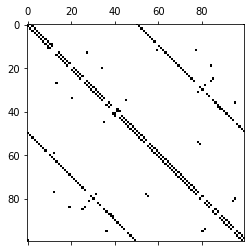

In [24]:
help(generate_ising_model)
help(solve_Ising_model)

# choose the problem size N, Ising model, and coupling distribution
N = 100
ising_model = 'mobius'
coupling_distribution = 'unweighted'

J = generate_ising_model(N, ising_model, coupling_distribution)

# rewire edges in the coupling matrix if necessary
J = rewire_regular_graph(J, N_rewirings=10)

spy(J)

In [19]:
solver_method = 'gurobi'
connectivity = 'sparse'
spins, energy_best, additional_data = solve_Ising_model(J, solver_method, connectivity)

for key, item in additional_data.items():
    vars()[key] = item
    print(key, '= %.3f' % item)
print(solver_method + ': Ising energy best = %.3f' % energy_best)
    
energy_upper_bound, spins_upper_bound = get_ising_energy_upper_bound(J)
print('Upper bound energy = %.3f' % energy_upper_bound)

if (solver_method == 'gurobi') and (energy_gap == 0):
    print('Coupling matrix can be optimised in polynomial time -> ', energy_upper_bound == energy_best)

energy_gap = 0.000
time_gurobi = 0.059
gurobi: Ising energy best = -280.000
Upper bound energy = -272.000
Coupling matrix can be optimised in polynomial time ->  False
